In [1]:
from importlib import reload

import universe
reload(universe)
from universe import *

import projection_kernel
reload(projection_kernel)
from projection_kernel import *

import p2d
reload(p2d)
from p2d import *

In [2]:
dss = 1.
lMin = 20.   
lMax = 3.e3  
nL = 101
fsky = 1.
L, dL, Nmodes, Le = generateEllBins(lMin, lMax, nL, fsky) 
paramsUnivPlanck15 = {
                    'output': 'dTk vTk mPk',#'lCl tCl pCl mPk',
            #       'l_max_scalars': 2000,
            #       'lensing': 'yes',
                    'A_s': 2.3e-9,
                    'n_s': 0.9624,
                    'h': 0.6712,
                    'N_ur': 3.046,
                    'Omega_b': 0.0493,
                    'Omega_cdm': 0.267,
                    'Omega_k': 0.,
                    'P_k_max_1/Mpc': 10.,
                    'non linear': 'halofit',
                    'z_max_pk': 100.
                    }
paramsHigh = {
                    'output': 'dTk vTk mPk',#'lCl tCl pCl mPk',
                    #'l_max_scalars': 2000,
                    #'lensing': 'yes',
                    'A_s': 2.3e-9 + dss*1.e-10,
                    'n_s': 0.9624 + dss*0.01,
                    'h': 0.6712 + dss*0.1,
                    #'N_ur': 3.046,
                    'Omega_b': 0.0493 + dss*0.0018,
                    'Omega_cdm': 0.267 + dss*0.0066,
                    'Omega_k': 0.,
                    'P_k_max_1/Mpc': 10.,
                    'non linear': 'halofit',
                    'z_max_pk': 100.
            }
paramsLow = {
                    'output': 'dTk vTk mPk',#'lCl tCl pCl mPk',
                    #'l_max_scalars': 2000,
                    #'lensing': 'yes',
                    'A_s': 2.3e-9 - dss*1.e-10,
                    'n_s': 0.9624 - dss*0.01,
                    'h': 0.6712 - dss*0.1,
                    #'N_ur': 3.046,
                    'Omega_b': 0.0493 - dss*0.0018,
                    'Omega_cdm': 0.267 - dss*0.0066,
                    'Omega_k': 0.,
                    'P_k_max_1/Mpc': 10.,
                    'non linear': 'halofit',
                    'z_max_pk': 100.
            }

generate: 20.0, 3000.0


In [41]:
def getDerivative(param, binedges, L):
    # high
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsHigh[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
    w_other = WeightTracerLSSTSourcesDESCSRDV1(u) 
    p2d_high = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
    dataHigh = p2d_high.P1h+p2d_high.P2h+p2d_high.Pnoise
    # low
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsLow[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
    w_other = WeightTracerLSSTSourcesDESCSRDV1(u)
    p2d_low = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
    dataLow = p2d_low.P1h+p2d_low.P2h+p2d_low.Pnoise
    
    result = (dataHigh - dataLow) / (paramsHigh[param]-paramsLow[param])
    return result

def getCov(p_gg, Nmodes):
    nData = nL
    covMat = np.zeros((nData, nData))
    cov = lambda Pac, Pbd, Pad, Pbc, Npairs: np.diagflat((Pac * Pbd + Pad * Pbc) / Npairs)
    i1=0
    i2=0 
    p = p_gg.P1h+p_gg.P2h+p_gg.Pnoise 
    covBlock = cov(p, p, p, p, Nmodes)
    covMat[i1*nL:(i1+1)*nL, i2*nL:(i2+1)*nL] = covBlock
    return covMat 

def getFisher(p_gg, params, binedges, L, Nmodes):
    nPar=len(params)
    fisherData = np.zeros((nPar, nPar))
    cov = getCov(p_gg, Nmodes)
    invCov = np.linalg.inv(cov)
    for i in range(nPar):
        for j in range(nPar):
            di = getDerivative(params[i], binedges, L)
            dj = getDerivative(params[j], binedges, L)
            fisherData[i,j] = np.dot(di.transpose(), np.dot(invCov, dj))
    return fisherData
    

In this code, the Fisher analysis is done for a single observable $C_{\ell}^{gg}$. This first test will be to run the analysis for the cross-product between the first redshift bin and the larger distribution of dn/dz, over the $\Omega_b$ and $\Omega_{CDM}$ parameters.

In [ ]:
u = UnivPlanck15()

# computing the binedges for WeightTracerLSSTBins
w = WeightTracerLSSTSourcesDESCSRDV1(u) 
nBins = 10
binedges = w.splitBins(nBins)

params = ['Omega_b', 'Omega_cdm']
w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
w_other = WeightTracerLSSTSourcesDESCSRDV1(u)
p2d = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
fisher = getFisher(p2d, params, binedges, L, Nmodes)

#calculating the covariance matrix
print(np.linalg.inv(fisher))

[[1.30434926e-05 1.97477444e-05]
 [1.97477444e-05 2.99037539e-05]]


### Checking $\sigma(f_{sky})$ behavior

I will now check the behavior of the errors as we change the fraction of the sky being used.

In [ ]:
fskies = np.arange(0.005, 1., 0.1)
sigma_b = np.zeros(len(fskies))
sigma_cdm = np.zeros(len(fskies))
for i in range(len(fskies)):
    L_new, dL, Nmodes_new, Le = generateEllBins(lMin, lMax, nL, fskies[i])
    p2d_f = P2dCross(u, u, w_bin, w_other, lBins=L_new, nProc=3, save=True)
    fisher_f = getFisher(p2d_f, params, binedges, L_new, Nmodes_new)
    cov_f = np.linalg.inv(fisher_f)
    sigma_b[i]=np.sqrt(cov_f[0][0])
    sigma_cdm[i]=np.sqrt(cov_f[1][1])

generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0
generate: 20.0, 3000.0


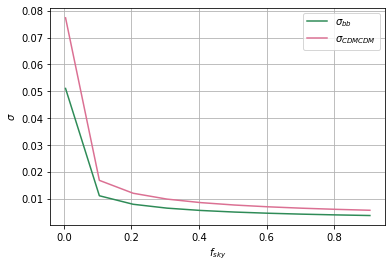

In [ ]:
plt.plot(fskies, sigma_b, color='seagreen', label=r'$\sigma_{bb}$')
plt.plot(fskies, sigma_cdm, color='palevioletred', label=r'$\sigma_{CDMCDM}$')
plt.ylabel(r'$\sigma$')
plt.xlabel(r'$f_{sky}$')
plt.legend(loc='upper right')
plt.grid()
plt.savefig('/Users/anacarolinaoliveira/Downloads/fsky_sigma.pdf')

### Testing Fisher for other $C_{\ell}$

Now, let's go back to the fsky=1 cases, and the test will now be done for other power spectra. I modify the derivative function to get the fisher matrix for the cross-cross for 2 adjacent redshift bins.

In [ ]:
def getDerivative(param, binedges, L):
    # high
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsHigh[param]
    u = Universe(params=parameters)
    w_bin1 = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    w_bin2 = WeightTracerLSSTBins(u, zphMin=binedges[4], zphMax=binedges[5])
    p2d_high = P2dCross(u, u, w_bin1, w_bin2, lBins=L, nProc=3, save=True)
    dataHigh = p2d_high.P1h+p2d_high.P2h+p2d_high.Pnoise
    # low
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsLow[param]
    u = Universe(params=parameters)
    w_bin1 = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    w_bin2 = WeightTracerLSSTBins(u, zphMin=binedges[4], zphMax=binedges[5])
    p2d_low = P2dCross(u, u, w_bin1, w_bin2, lBins=L, nProc=3, save=True)
    dataLow = p2d_low.P1h+p2d_low.P2h+p2d_low.Pnoise
    result = (dataHigh - dataLow) / (paramsHigh[param]-paramsLow[param])
    return result

w_bin1 = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
w_bin2 = WeightTracerLSSTBins(u, zphMin=binedges[4], zphMax=binedges[5])

p2d_crossbins = P2dCross(u, u, w_bin1, w_bin2, lBins=L, nProc=3, save=True)
fisher = getFisher(p2d_crossbins, params, binedges, L, Nmodes)

print(np.linalg.inv(fisher))

[[2.59729706e-06 3.85266391e-06]
 [3.85266391e-06 5.71836339e-06]]


Now the auto-auto for 1 bin:

In [ ]:
def getDerivative(param, binedges, L):
    # high
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsHigh[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    p2d_high = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
    dataHigh = p2d_high.P1h+p2d_high.P2h+p2d_high.Pnoise
    # low
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsLow[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])
    p2d_low = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
    dataLow = p2d_low.P1h+p2d_low.P2h+p2d_low.Pnoise
    result = (dataHigh - dataLow) / (paramsHigh[param]-paramsLow[param])
    return result

w_bin = WeightTracerLSSTBins(u, zphMin=binedges[3], zphMax=binedges[4])

p2d_auto = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
fisher = getFisher(p2d_auto, params, binedges, L, Nmodes)

print(np.linalg.inv(fisher))

[[2.85136533e-06 4.25397026e-06]
 [4.25397026e-06 6.35017281e-06]]


### Test different parameters 

In [19]:
u = UnivPlanck15()
# computing the binedges for WeightTracerLSSTBins
w = WeightTracerLSSTSourcesDESCSRDV1(u)
nBins = 10
binedges = w.splitBins(nBins)

params = ['A_s', 'Omega_b']
w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
w_other = WeightTracerLSSTSourcesDESCSRDV1(u)
p2d = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
fisher = getFisher(p2d, params, binedges, L, Nmodes)

In [20]:
print(np.linalg.inv(fisher))
print(fisher)

[[2.58176125e-20 1.49904067e-12]
 [1.49904067e-12 8.70562231e-05]]
[[ 1.88886264e+23 -3.25247503e+15]
 [-3.25247503e+15  5.60165855e+07]]


$\sigma_{A_sA_s}^2$ is pretty low. Let's take a look at the derivative of the data vector wrt to it:

In [58]:
def getDerivativedebug(param, binedges, L):
    #original 
    parameters = paramsUnivPlanck15
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[5], zphMax=binedges[6])
    w_other = WeightTracerLSSTSourcesDESCSRDV1(u) 
    p2d_ori = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
    dataOriginal = p2d_ori.P1h+p2d_ori.P2h+p2d_ori.Pnoise
    # high
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsHigh[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[5], zphMax=binedges[6])
    w_other = WeightTracerLSSTSourcesDESCSRDV1(u) 
    p2d_high = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
    dataHigh = p2d_high.P1h+p2d_high.P2h+p2d_high.Pnoise
    # low
    parameters = paramsUnivPlanck15.copy()
    parameters[param] = paramsLow[param]
    u = Universe(params=parameters)
    w_bin = WeightTracerLSSTBins(u, zphMin=binedges[5], zphMax=binedges[6])
    w_other = WeightTracerLSSTSourcesDESCSRDV1(u)
    p2d_low = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
    dataLow = p2d_low.P1h+p2d_low.P2h+p2d_low.Pnoise
    # print(dataOriginal/dataHigh)
    # print(dataOriginal/dataLow)
    print(dataHigh/dataOriginal - dataLow/dataOriginal)
    result = (dataHigh - dataLow) / (paramsHigh[param]-paramsLow[param])
    return result

In [59]:
getDerivativedebug('A_s', binedges, L)

[0.0861938  0.0859967  0.08605928 0.08639093 0.08692227 0.08744257
 0.08784288 0.08817906 0.08854667 0.08899928 0.08953836 0.09012715
 0.09071211 0.09124821 0.0917159  0.09212275 0.09249297 0.09285434
 0.09322908 0.09362984 0.09405948 0.09451304 0.09498019 0.09544843
 0.09590618 0.09634441 0.09675861 0.09714767 0.09751464 0.09786413
 0.09820216 0.09853434 0.0988654  0.09919892 0.09953639 0.09987868
 0.1002246  0.10057273 0.10092089 0.10126678 0.10160807 0.10194327
 0.10227083 0.10258995 0.10290071 0.10320314 0.10349794 0.10378602
 0.10406843 0.10434627 0.10462031 0.10489146 0.10516059 0.10542792
 0.1056937  0.10595818 0.10622121 0.10648261 0.10674223 0.10699962
 0.10725448 0.10750665 0.10775588 0.10800179 0.10824428 0.10848336
 0.10871898 0.10895107 0.10917982 0.10940535 0.10962776 0.10984714
 0.11006376 0.11027786 0.11048952 0.11069883 0.11090596 0.11111111
 0.11131431 0.11151559 0.111715   0.11191263 0.11210854 0.11230264
 0.11249491 0.11268535 0.11287401 0.11306088 0.11324589 0.1134

array([697.0083458 , 410.3660265 , 335.49046748, 268.23254893,
       217.69652861, 188.16238526, 171.89783273, 160.72534961,
       150.18254515, 139.19597582, 128.41000009, 118.76206102,
       110.79884613, 104.56366948,  99.75490477,  95.93302302,
        92.67976156,  89.68479663,  86.77020829,  83.87334281,
        81.00933631,  78.23180224,  75.60295454,  73.17119708,
        70.96284653,  68.98198961,  67.21189002,  65.62622648,
        64.19039484,  62.87157048,  61.63963595,  60.47079328,
        59.34854717,  58.26156701,  57.20595697,  56.1796329 ,
        55.18492888,  54.22455331,  53.30143477,  52.41807493,
        51.57653047,  50.77636298,  50.01725878,  49.29750778,
        48.61408845,  47.9642272 ,  47.34457153,  46.75193691,
        46.18306996,  45.63510137,  45.10601975,  44.59373633,
        44.09643471,  43.61325611,  43.14337203,  42.68607868,
        42.24108858,  41.80811351,  41.38687907,  40.97745136,
        40.5796634 ,  40.19318559,  39.81779862,  39.45

### Cross check plotting 

In [60]:
u = UnivPlanck15()

# computing the binedges for WeightTracerLSSTBins
w = WeightTracerLSSTSourcesDESCSRDV1(u)
lMin = 1.   
lMax = 1.e3 
nBins = 10
binedges = w.splitBins(nBins)
params = ['Omega_b', 'Omega_cdm', 'Omega_k', 'A_s', 'h', 'n_s']
L, dL, Nmodes, Le = generateEllBins(lMin, lMax, nL, fsky)

w_bin = WeightTracerLSSTBins(u, zphMin=binedges[0], zphMax=binedges[1])
w_other = WeightTracerLSSTSourcesDESCSRDV1(u)
P = P2dCross(u, u, w_bin, w_other, lBins=L, nProc=3, save=True)
Cl = P.P1h+P.P2h+P.Pnoise

generate: 1.0, 1000.0


##### $\frac{dlnC_{\ell}}{dln(param)}$

In [41]:
dlnCl = np.zeros((len(params), 101))
for i in range(len(params)): 
    deriv = getDerivative(params[i], binedges, L)
    frac = paramsUnivPlanck15[params[i]] / Cl
    dlnCl[i] = frac * deriv

generate: 1.0, 1000.0


/Users/anacarolinaoliveira/miniconda3/envs/LIMenv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


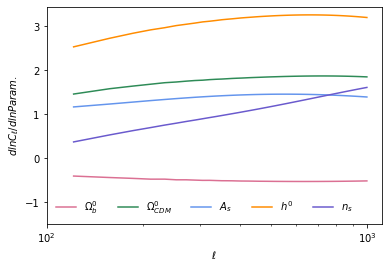

In [53]:
plt.plot(L[1:], dlnCl[0][1:], color='palevioletred', label=r'$\Omega_b^0$')
plt.plot(L[1:], dlnCl[1][1:], color='seagreen', label=r'$\Omega_{CDM}^0$')
plt.plot(L[1:], dlnCl[3][1:], color='cornflowerblue', label=r'$A_s$')
plt.plot(L[1:], dlnCl[4][1:], color='darkorange', label=r'$h^0$')
plt.plot(L[1:], dlnCl[5][1:], color='slateblue', label=r'$n_s$')
plt.xscale('log')
plt.legend(frameon=False, ncol=len(params))
plt.ylim(bottom=-1.5)
plt.xlim(left=100)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$d ln C_{\ell} / d ln Param.$')
plt.savefig('/Users/anacarolinaoliveira/Downloads/dlnCl_check.pdf')

##### $\ell C_{\ell}$

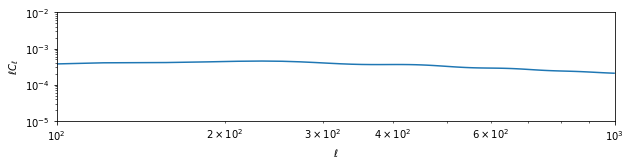

In [97]:
w_bin = WeightTracerLSSTBins(u, zphMin=binedges[8], zphMax=binedges[9])
Pauto = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
Cl_auto = Pauto.P1h+Pauto.P2h+Pauto.Pnoise
lCl = L*Cl_auto
fig = plt.figure(figsize=(10, 2))
plt.plot(L, lCl)
plt.xscale('log')
plt.yscale('log')
plt.xlim(left=100, right=1000)
plt.ylim(bottom=1e-05, top=0.01)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell C_{\ell}$')
plt.savefig('/Users/anacarolinaoliveira/Downloads/lCl_check.pdf')


### $\frac{\sigma_{\ell}}{C_{\ell}}$

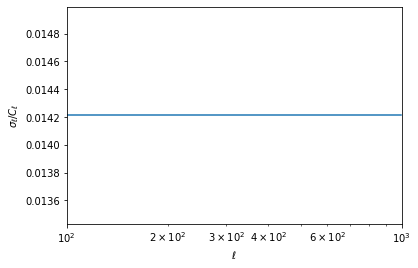

In [96]:
Pauto = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
Cl_auto = Pauto.P1h+Pauto.P2h+Pauto.Pnoise
covMatrix = getCov(Pauto, Nmodes)
sigmas = np.array([np.sqrt(covMatrix[i][i]) for i in range(len(covMatrix))])
plt.plot(L, sigmas/Cl_auto)
plt.xscale('log')
plt.xlim(left=100, right=1000)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma_{\ell} / C_{\ell}$')
plt.savefig('/Users/anacarolinaoliveira/Downloads/sigmalCl_check.pdf')


For the noiseless power spectrum, the relative uncertainty is independent of $\ell$, which I think goes back to the fact that we have the same number of modes per $\ell$ bin. 

### SNR


In [95]:
w_bin = WeightTracerLSSTBins(u, zphMin=binedges[8], zphMax=binedges[9])
Pauto = P2dAuto(u, u, w_bin, lBins=L, nProc=3, name='bin', save=True)
Cl_auto = Pauto.P1h+Pauto.P2h+Pauto.Pnoise
covMatrix = getCov(Pauto, Nmodes)
invertedCov = np.linalg.inv(covMatrix)
snr = np.sqrt(np.dot(Cl_auto.transpose(), np.dot(invertedCov, Cl_auto)))
print(snr)

707.1064276330685
